### APRENDIZAJE PROFUNDO PARA PROCESAMIENTO DE INFORMACIÓN BIOMÉTRICA

# PRÁCTICA 1
### GRUPO 
* Hajar Boulehdid
* Sofía Santos Schmick
* Andrés Teruel Fernández

---


In [8]:
import os
import numpy as np

from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

from face_recognition_main import *

In [3]:
# Paths and parameters:
images_directory = 'imagenes'
bbdd_10_ppl_directory = 'bbdd_10_personas'
bbdd_directory = os.path.join('DiveFace4K_120', '4K_120')

---

## TAREA 1.0:

 - Revisa y entiende el código
 - Compara con la imagen 2 o 3 con las anterires.

In [5]:
images = [os.path.join(images_directory, f"{i}.jpg") for i in range(4)]
images

['imagenes\\0.jpg', 'imagenes\\1.jpg', 'imagenes\\2.jpg', 'imagenes\\3.jpg']

In [6]:
""""Comparamos si son la misma persona a través de una simple.Detectamos las caras de las imagenes. Imagen0 y Imagen1"""

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        image1 = images[i]
        image2 = images[j]
        
        print(f"Image {i} vs image {j}: ", end='')
        compare_images(image1, image2, crop_image=True)

Image 0 vs image 1: 

AttributeError: 'NoneType' object has no attribute 'shape'

---

## TAREA 1.1: 

 - Generate a small database with a minimum of 3 images per person and 10 persons.
 - Develop a script to calculate the FAR and FRR curves.   

 Creando la base de datos de embeddings...
 Base de datos de embeddings creada con éxito.


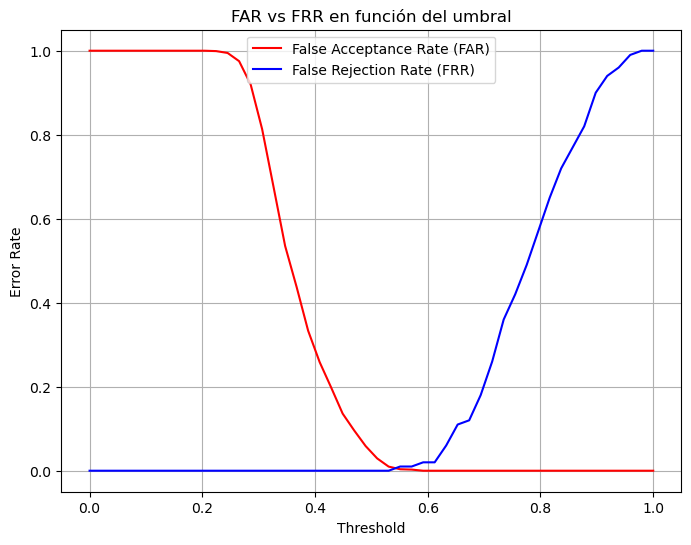

In [5]:
# Extraer los embeddings de la bbdd
embeddings_db = create_embeddings_db(bbdd_10_ppl_directory)

# Generar FAR, FRR y el gráfico
fars, frrs = calculate_far_frr_plot(embeddings_db)

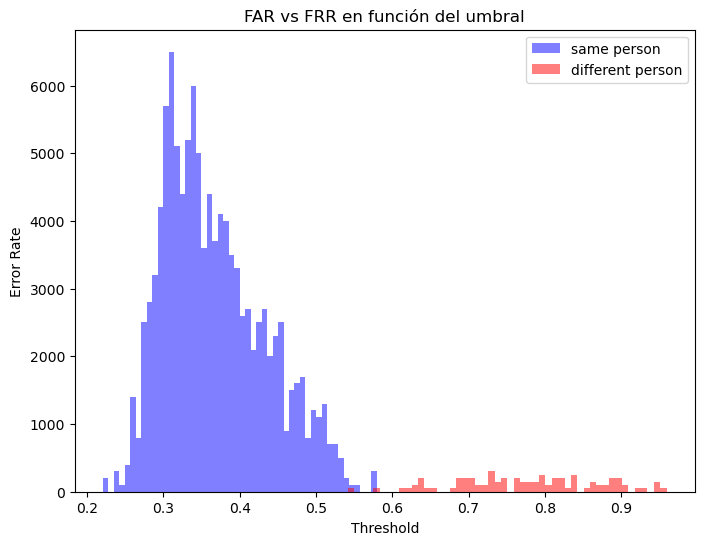

In [6]:
## pintar los histogramas, ver qeu va ha haber solapamiento, histograma de los porpios scores.la distancia que le ha dado a la msima persona, distancia que les ha dado a personas iguales, y difernetes,
#  pintar los histogramas de los scores de dsitancia dado la misma perosna
same_person, different_person = calcular_histograma(embeddings_db)

In [7]:
print(len(same_person))
print(len(different_person))

112500
5000


---

## TAREA 1.2:

 - Read the DiveFace database and obtain the embeddings of 50 face images (1 image per subject) from the 6 demographic groups (50*6=300 embeddings in total).
 - DiveFace contains face images from 3 demographic groups (3 ethnicity and 2 gender)

In [8]:
# Llamar a la función para crear la base de datos de embeddings
embeddings_db_demographic = create_embeddings_6_groups(bbdd_directory)

# Verificar la cantidad de embeddings por grupo
for group_name, embeddings in embeddings_db_demographic.items():
    print(f"{group_name}: {len(embeddings)} embeddings")

 Creando la base de datos de embeddings...
HN4K_120: 50 embeddings
HB4K_120: 50 embeddings
MN4K_120: 50 embeddings
HA4K_120: 50 embeddings
MA4K_120: 50 embeddings
MB4K_120: 50 embeddings


---

## TAREA 1.3:

 - Using t-SNE, represent the embeddings and its demographic group. Can you differentiate the different demographic groups?
 

Shape de embeddings_matrix: (300, 2048)
Perplexity usada en t-SNE: 30
Shape de embeddings_matrix antes de t-SNE: (300, 2048)


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


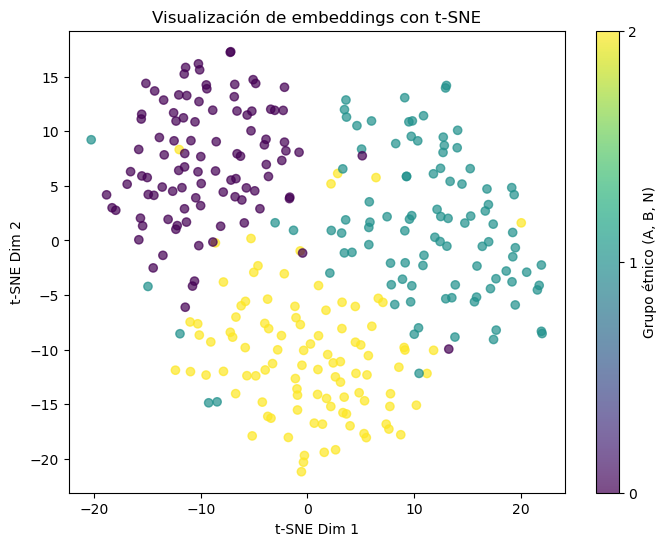

In [9]:
# Aplicar t-SNE a los embeddings
embeddings_2d, labels_list , embeddings_matrix = apply_tsne(embeddings_db_demographic)

---

## TAREA 1.4:
 * Using the ResNet-50 embedding (freeze the model), train your own attribute classifiers (ethnicity and gender). 
 *  Recommendation: use a simple dense layer with a softmax output. Divide DiveFace into train and test.

TODO: revisar la presentación porque ponía alguna cosa sobre este apartado

In [10]:
X = all_embeddings

# Convertir etiquetas a números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convierte categorías en enteros

# Convertir a One-Hot Encoding
y = to_categorical(y, num_classes=6)  # Si hay 6 clases

print("X shape:", X.shape)
print("y shape:", y.shape)

NameError: name 'all_embeddings' is not defined

In [ ]:

for layer in feature_extractor.layers:
    layer.trainable = False  # Congelar capas


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_classes = y.shape[1]  # Asegura que coincida con las categorías

classifier = Sequential([
    Input(shape=(X.shape[1],)),  # Tamaño de los embeddings
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Clasificación multiclase
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier.summary()
classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')


In [ ]:
input_size = 2048

def baseline_model():
    model = Sequential()
    model.add(Dense(60, input_dim=2048, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Compile model
X = np.array(X).astype(float)
y = np.asarray(y)
y = np_utils.to_categorical(y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

LO NUEVO

In [15]:
# Cargar los datos de embedings500
loaded_data = np.load("embeddings_db.npz")
embeddings_db_demographic_500= {k: loaded_data[k] for k in loaded_data}
# estructura del embeddings_db_demographic_500
print(embeddings_db_demographic_500.keys())


# Filtrar solo los grupos 'HA4K_120' y 'MA4K_120'
grupos_filtrados = ['HA4K_120', 'MA4K_120']
embeddings_db_A = {k: v for k, v in embeddings_db_demographic_500.items() if k in grupos_filtrados}
 
# Verificar el resultado
print(f"Grupos en el diccionario filtrado: {list(embeddings_db_A.keys())}")

dict_keys(['HA4K_120', 'HB4K_120', 'HN4K_120', 'MA4K_120', 'MB4K_120', 'MN4K_120'])
Grupos en el diccionario filtrado: ['HA4K_120', 'MA4K_120']


In [ ]:
def get_X_y(embeddings_db):
    """
    Convierte un diccionario de embeddings en matrices X e y.
    Parámetros:
    - embeddings_db: dict, diccionario con claves que indican el grupo y valores con listas de embeddings.
 
    Retorna:
    - X: numpy array con los embeddings.
    - y: numpy array con las etiquetas de género (one-hot encoded).
    """
    X = []
    y = []
 
    for label, embeddings in embeddings_db.items():
        gender = 0 if label[0] == 'H' else 1  # Hombre (0), Mujer (1)
        for emb in embeddings:
            X.append(emb)
            y.append(gender)
 
    X = np.array(X).astype(float)
    y = to_categorical(y)  # Convertir a one-hot encoding

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
 
    return X_train, X_test, y_train, y_test


def gender_model():
    model = Sequential([
        Dense(60, input_dim=2048, activation='relu'),
        Dense(2, activation='softmax')  # 2 clases: Hombre/Mujer
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
 

ASIAN GROUP

In [ ]:
X_train_A, X_test_A, y_train_A, y_test_A = get_X_y(embeddings_db_A)

# Crear el clasificador Keras
estimator_A = KerasClassifier(build_fn=gender_model, epochs=10, batch_size=5, verbose=1) # he puesto 10 epocas para probar
 
# Validación cruzada con 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_A = cross_val_score(estimator_A, X_train_A, y_train_A, cv=kfold)

print("Accuracy del modelo de género (Grupo A - Asiáticos): %.2f%% (%.2f%%)" % (results_A.mean()*100, results_A.std()*100))


Epoch 1/10


C:\Users\sofia\AppData\Local\Temp\ipykernel_12912\4000709209.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=gender_model, epochs=10, batch_size=5, verbose=1) # he puesto 10 epocas para probar


108/108 [==============================] - 0s 1ms/step - loss: 0.3716 - accuracy: 0.9204
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0673 - accuracy: 0.9907
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0281 - accuracy: 0.9981
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 9/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.0606 - accuracy: 0.9833
Epoch 1/10
1

BLACK GROUP

In [ ]:
# Filtrar solo los grupos 'HA4K_120' y 'MA4K_120'
grupos_filtrados = ['HB4K_120', 'MB4K_120']
embeddings_db_B = {k: v for k, v in embeddings_db_demographic_500.items() if k in grupos_filtrados}

print(f"Grupos en el diccionario filtrado: {list(embeddings_db_B.keys())}")

X_train_B, X_test_B, y_train_B, y_test_B = get_X_y(embeddings_db_B)
estimator_B = KerasClassifier(build_fn=gender_model, epochs=10, batch_size=5, verbose=1) # he puesto 10 epocas para probar
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_B = cross_val_score(estimator_B, X_train_B, y_train_B, cv=kfold)

print("Accuracy del modelo de género (Grupo A - Asiáticos): %.2f%% (%.2f%%)" % (results_B.mean()*100, results_B.std()*100))

Grupos en el diccionario filtrado: ['HB4K_120', 'MB4K_120']
Epoch 1/10


C:\Users\sofia\AppData\Local\Temp\ipykernel_12912\1302112043.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=gender_model, epochs=10, batch_size=5, verbose=1) # he puesto 10 epocas para probar


108/108 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.9167
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0685 - accuracy: 0.9926
Epoch 3/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9944
Epoch 4/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 8/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 9/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 1/10
1

CAUCASIAN GROUP

In [ ]:
# Filtrar solo los grupos 'HA4K_120' y 'MA4K_120'
grupos_filtrados = ['HN4K_120', 'MN4K_120']
embeddings_db_N = {k: v for k, v in embeddings_db_demographic_500.items() if k in grupos_filtrados}
print(f"Grupos en el diccionario filtrado: {list(embeddings_db_N.keys())}")

X_train_N, X_test_N, y_train_N, y_test_N = get_X_y(embeddings_db_N)
estimator_N = KerasClassifier(build_fn=gender_model, epochs=10, batch_size=5, verbose=1) # he puesto 10 epocas para probar
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_N = cross_val_score(estimator_N, X_train_N, y_train_N, cv=kfold)

print("Accuracy del modelo de género (Grupo A - Asiáticos): %.2f%% (%.2f%%)" % (results_N.mean()*100, results_N.std()*100))

Grupos en el diccionario filtrado: ['HN4K_120', 'MN4K_120']
Epoch 1/10


C:\Users\sofia\AppData\Local\Temp\ipykernel_12912\3574756926.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=gender_model, epochs=10, batch_size=5, verbose=1) # he puesto 10 epocas para probar


108/108 [==============================] - 0s 1ms/step - loss: 0.3763 - accuracy: 0.9037
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.9852
Epoch 3/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0485 - accuracy: 0.9870
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.9926
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 0.9944
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0138 - accuracy: 0.9981
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 9/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.9500
Epoch 1/10
1

---

## TAREA 2.1:


---

## TAREA 2.2:

---

## TAREA 2.3:

---

## TAREA 2.4: